In [14]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import skimage
import os
import pickle
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

nAnchors = 24
batchSize = 16
numEpochs = 400
device = "cuda"

In [15]:
class AnchorDataSet(torch.utils.data.Dataset):
    def __init__(self, file, transform = None, target_transform=None):
        super(AnchorDataSet, self).__init__()
        self.df = pd.read_pickle(file)
        self.transform = transform
        self.target_transform=target_transform
     
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):
        
        feats = self.df.loc[idx, "Features"].astype(np.double)
        anchorDists = self.df.loc[idx, "AnchorDists"].astype(np.double)
        
        dofs = np.array([self.df.loc[idx,"Z"],self.df.loc[idx,"W"],self.df.loc[idx,"P"],self.df.loc[idx,"Q"],self.df.loc[idx,"R"]]).astype(np.double)
        
        xy = np.array([self.df.loc[idx,"X"], self.df.loc[idx,"Y"]]).astype(np.double)
        imageFile = self.df.loc[idx, "ImageFile"]
        ImageNum = self.df.loc[idx,"ImageNum"]

        return {"Features": feats,
                "anchorDists": anchorDists,
                "dofs": dofs,
                "xy": xy,
                "ImageFile": imageFile,
                "ImageNum": ImageNum}


class anchorNet(nn.Module):
    def __init__(self, nAnchors):
        super(anchorNet, self).__init__()
        self.classifier = nn.Linear(2208, nAnchors)
        self.regressor = nn.Linear(2208, 2*nAnchors)
        self.dof_regressor = nn.Linear(2208, 5)
        self.softmax = nn.Softmax(dim=1)
        self.double()
    
    def forward(self, feats):

        classify = self.softmax(self.classifier(nn.functional.relu(feats))) # TODO: ReLU useful?
        regress = self.regressor(nn.functional.relu(feats))
        dof_regress = self.dof_regressor(nn.functional.relu(feats))

        return classify, regress, dof_regress

def custom_loss(classify, regress, dof_regress, anchorDistsGt, dofGt, dofLoss, crossEntropy, factors = [2.4,0,0.5]):
    # TODO: Possible Flaw (or the reason why this works?):
    # The net tries to learn realtive position to each anchorpoint
    # independently, so we have a large amount of degrees of freedom, even though relative
    # position to anchor points should have 2 DOF. Maybe try using more anchorpoints to
    # proof this point.

    """
    classify: output of anchor classifier
    regress: output of regressor
    dof_regress: output of dof_regressor
    anchorDistsGt: true distance to all anchor poitns
    dofGt: true remaining 4 DOF
    dofLoss: loss function used for dof_regressor
    factors: list of hyperparameters for weighting of different loss terms
    """

    dist = regress.reshape(-1, nAnchors, 2) - anchorDistsGt

    # TODO: Use softmax on gt-dof and dof for normalization
    lossXY = torch.sum(torch.linalg.norm(dist, axis = -1) * classify)
    
    nearest = torch.argmin(torch.linalg.norm(anchorDistsGt, axis=-1), axis=-1)

    return torch.sum(factors[0] * lossXY) + factors[1]*crossEntropy(classify, nearest) + factors[2] * dofLoss(dof_regress, dofGt)


In [26]:
trainDataset = AnchorDataSet(file= f"data/ShopFacade/traindata_with_features_and_anchors{nAnchors}.pkl")
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=16, shuffle=False, num_workers=0)

testDataset = AnchorDataSet(file= f"data/ShopFacade/testdata_with_features_and_anchors{nAnchors}.pkl")
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=16, shuffle=False, num_workers=0)

myNet = anchorNet(nAnchors=nAnchors).to(device)
dofLoss = nn.MSELoss().to(device)
crossEntropy = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(myNet.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)

myAnchors = torch.from_numpy(np.loadtxt(f"data/ShopFacade/anchors{nAnchors}.txt")).to(device)

epochs = []
testXY = []
testZ = []
testRot = []

for epoch in range(numEpochs):
    epochLoss = 0
    trainDists = []
    zTrain = []
    dofTrain = []

    for i, data in enumerate(trainDataloader):

        myNet.train()

        optimizer.zero_grad()
        
        myFeats = data["Features"]
        myFeats = myFeats.to(device)

        myAnchorDistsGt = data["anchorDists"]
        myAnchorDistsGt = myAnchorDistsGt.to(device)

        myDofGt = data["dofs"]
        myDofGt = myDofGt.to(device)

        myXyGt = data["xy"]
        myXyGt = myXyGt.to(device)

        classify, regress, dof_regress = myNet.forward(myFeats)
        loss = custom_loss(classify, regress, dof_regress, anchorDistsGt=myAnchorDistsGt, dofGt=myDofGt, dofLoss=dofLoss, crossEntropy=crossEntropy, factors=[2.4,1.,0.5])
        loss.backward()
        
        optimizer.step()
        epochLoss += loss.data.item()
        
        with torch.no_grad():
            bestAnchor = torch.argmax(classify, axis=1).to(device)

            dist = 0
            dofDist = 0

            for j in range(bestAnchor.size()[0]):
                dist += torch.linalg.norm((myAnchors[bestAnchor[j], :] + regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]) - (myXyGt)[j])
                dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

            trainDists.append(dist.data.item() / bestAnchor.size()[0])
            zTrain.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
            dofTrain.append(dofDist/bestAnchor.size()[0])

            
    if (epoch+1)%100==0:

        print(f"Loss in epoch {epoch}: ", epochLoss)
        print("Training Dist: ", np.mean(trainDists),"m")
        print("z dist: ", np.mean(zTrain), "m, dof dist: ", np.mean(dofTrain), "°")

    # ===========TESTING=============

    if epoch%5 == 0:
        
        epochs.append(epoch)    
        testDists = []
        zTest = []
        dofTest = []

        for idx, data in enumerate(testDataloader):

            myNet.eval()

            myFeats = data["Features"]
            myFeats = myFeats.to(device)

            myAnchorDistsGt = data["anchorDists"]
            myAnchorDistsGt = myAnchorDistsGt.to(device)

            myDofGt = data["dofs"]
            myDofGt = myDofGt.to(device)

            myXyGt = data["xy"]
            myXyGt = myXyGt.to(device)

            classify, regress, dof_regress = myNet.forward(myFeats)
            
            bestAnchor = torch.argmax(classify, axis=1).to(device)

            dist = 0
            dofDist = 0

            for j in range(bestAnchor.size()[0]):
                greg = regress.reshape(-1,nAnchors,2)[j,bestAnchor[j], :]
                if(epoch)%20==0:
                    print("Regeressor: ", greg)
                cook = torch.abs(myAnchors[bestAnchor[j], :] - greg)
                if(epoch)%20==0:
                    print("anchors-reg: ", cook)
                    print("XY:", (myXyGt)[j])
                dist += torch.linalg.norm(cook - (myXyGt)[j])
                dofDist += np.mean(Rotation.from_quat(dof_regress[j,1:].cpu().detach().numpy()).as_euler("xyz", degrees=True) - Rotation.from_quat(myDofGt[j,1:].cpu().detach().numpy()).as_euler("xyz",degrees=True))

            testDists.append(dist.data.item() / bestAnchor.size()[0])
            zTest.append(torch.mean(dof_regress[:,0] - myDofGt[:,0]).data.item())
            dofTest.append(dofDist/bestAnchor.size()[0])
        
        testXY.append(np.mean(testDists))
        testZ.append(np.mean(zTest))
        testRot.append(np.mean(dofTest))

testResults = pd.DataFrame(data={"Epochs":epochs, "XY_dist":testXY, "Z_Dist":testZ,"angle_error":testRot})
testResults.to_csv(f"./data/ShopFacade/testResults_with_{nAnchors}anchors.csv")

Regeressor:  tensor([0.7338, 0.2465], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
anchors-reg:  tensor([4.7634, 0.4863], device='cuda:0', dtype=torch.float64,
       grad_fn=<AbsBackward0>)
XY: tensor([-9.2044, -8.3260], device='cuda:0', dtype=torch.float64)
Regeressor:  tensor([0.7338, 0.2465], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
anchors-reg:  tensor([4.7634, 0.4863], device='cuda:0', dtype=torch.float64,
       grad_fn=<AbsBackward0>)
XY: tensor([-7.8212, -7.8835], device='cuda:0', dtype=torch.float64)
Regeressor:  tensor([0.7338, 0.2465], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
anchors-reg:  tensor([4.7634, 0.4863], device='cuda:0', dtype=torch.float64,
       grad_fn=<AbsBackward0>)
XY: tensor([-8.4826, -8.1583], device='cuda:0', dtype=torch.float64)
Regeressor:  tensor([0.7338, 0.2465], device='cuda:0', dtype=torch.float64,
       grad_fn=<SliceBackward0>)
anchors-reg:  tensor([4.7634, 0.4

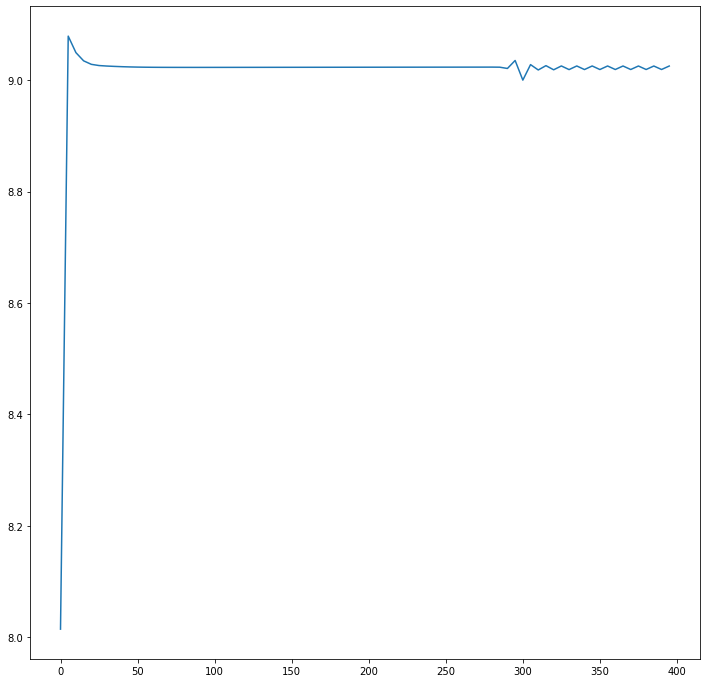

In [10]:
plt.figure(figsize=(12,12))
plt.plot(testResults["Epochs"], testResults["XY_dist"])
plt.show()